In [1]:
import sys

sys.path.append('/home/max/myrepos/vlstm_cuda/')

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
import triton
import triton.language as tl
import math

In [2]:
triton.runtime.driver.active.get_current_target()

GPUTarget(backend='cuda', arch=89, warp_size=32)

In [3]:
from src_triton.mlstm_parallel_fwbw_v0.mlstm_bw2 import mlstm_bw
from src_triton.mlstm_parallel_fwbw_v0.torch_impl import vlstm_parallel_w_groupnorm_torch_bw as mlstm_bw_torch
from plot_utils import plot_numerical_diffs_single

In [4]:
list(range(0,0*8,4))

[]

In [5]:
S = 128 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 256 # dim per head

DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

BLOCK_Q = 16
BLOCK_KV = 16

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# # vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 100.
# # vs = torch.zeros((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs[:,:,1,0] = 7.
# qs[:,:,1,0] = 1.

# vs[:,:,1,16] = 8.
# qs[:,:,1,16] = 1.
# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S) / 10.
# igs = torch.zeros((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S), device=DEVICE, dtype=DTYPE)
# fgs = torch.ones((B, NH, S), device=DEVICE, dtype=DTYPE) *0.9 - torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE) / 100.
fgs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE)

dH = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vecN = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
vecM = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dH_half = dH.to(dtype=dtype_fp16)
vecN_half = vecN.to(dtype=dtype_fp16)
vecM_half = vecM.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dH_bf16 = dH.to(dtype=dtype_bf16)
vecN_bf16 = vecN.to(dtype=dtype_bf16)
vecM_bf16 = vecM.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
dQ_pt_p, dK_pt_p, dV_pt_p, dI_pt_p, dF_pt_p = mlstm_bw_torch(matDeltaHtilde=dH, matQ=qs, matK=ks, matV=vs, vecN=vecN, vecM=vecM, vecI=igs.unsqueeze(-1), vecF=fgs.unsqueeze(-1))

In [10]:
dQ_pt_p_half, dK_pt_p_half, dV_pt_p_half, dI_pt_p_half, dF_pt_p_half = mlstm_bw_torch(
    matDeltaHtilde=dH_half,
    matQ=qs_half,
    matK=ks_half,
    matV=vs_half,
    vecN=vecN_half,
    vecM=vecM_half,
    vecI=igs_half.unsqueeze(-1),
    vecF=fgs_half.unsqueeze(-1),
)

In [11]:
dQ_pt_p_bf16, dK_pt_p_bf16, dV_pt_p_bf16, dI_pt_p_bf16, dF_pt_p_bf16 = mlstm_bw_torch(
    matDeltaHtilde=dH_bf16,
    matQ=qs_bf16,
    matK=ks_bf16,
    matV=vs_bf16,
    vecN=vecN_bf16,
    vecM=vecM_bf16,
    vecI=igs_bf16.unsqueeze(-1),
    vecF=fgs_bf16.unsqueeze(-1),
)

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"dQ match: {torch.allclose(dQ_pt_p_half.float(), dQ_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_pt_p_half - dQ_pt_p))}")
print(f"dK match: {torch.allclose(dK_pt_p_half.float(), dK_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_pt_p_half - dK_pt_p))}")
print(f"dV match: {torch.allclose(dV_pt_p_half.float(), dV_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_pt_p_half - dV_pt_p))}")
print(f"dI match: {torch.allclose(dI_pt_p_half.float(), dI_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_pt_p_half - dI_pt_p))}")
print(f"dF match: {torch.allclose(dF_pt_p_half.float(), dF_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_pt_p_half - dF_pt_p))}")

print(f"====== Full -> bfloat16 ======")
print(f"dQ match: {torch.allclose(dQ_pt_p_bf16.float(), dQ_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_pt_p_bf16 - dQ_pt_p))}")
print(f"dK match: {torch.allclose(dK_pt_p_bf16.float(), dK_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_pt_p_bf16 - dK_pt_p))}")
print(f"dV match: {torch.allclose(dV_pt_p_bf16.float(), dV_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_pt_p_bf16 - dV_pt_p))}")
print(f"dI match: {torch.allclose(dI_pt_p_bf16.float(), dI_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_pt_p_bf16 - dI_pt_p))}")
print(f"dF match: {torch.allclose(dF_pt_p_bf16.float(), dF_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_pt_p_bf16 - dF_pt_p))}")

====== Full -> Half ======
dQ match: False, max diff: 3.5247154235839844
dK match: False, max diff: 3.955707550048828
dV match: False, max diff: 14.7677001953125
dI match: False, max diff: 18.32525634765625
dF match: False, max diff: 8.6019287109375
====== Full -> bfloat16 ======
dQ match: False, max diff: 126.6177978515625
dK match: False, max diff: 110.5936279296875
dV match: False, max diff: 77.7677001953125
dI match: False, max diff: 525.267333984375
dF match: False, max diff: 166.8955078125


### compare errors triton vs pytorch

In [13]:
dQ_tr_p_half, dK_tr_p_half, dV_tr_p_half, dI_tr_p_half, dF_tr_p_half = mlstm_bw(
    matDeltaHtilde=dH_half,
    matQ=qs_half,
    matK=ks_half,
    matV=vs_half,
    vecN=vecN_half.squeeze(-1),
    vecM=vecM_half.squeeze(-1),
    vecI=igs_half,
    vecF=fgs_half,
    # BLOCK_Q=BLOCK_Q,
    # BLOCK_KV=BLOCK_KV,
)

loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_bw2.py":286:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_bw2.py":286:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_bw2.py":286:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_bw2.py":286:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_bw2.py":286:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_bw2.py":286:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/src_triton/mlstm_parallel_fwbw_v0/mlstm_bw2.py":286:11): error: operation scheduled before its operands
loc("/home/max/myrepos/vlstm_cuda/

In [14]:
torch.abs(dI_tr_p_half - dI_pt_p.squeeze(-1))

tensor([[[3.1393e-01, 1.2094e+00, 1.7829e-02, 6.5445e-02, 1.7134e-02, 1.8492e-02, 8.7418e-02, 7.4108e-02, 9.5713e-04, 2.0428e-02, 7.9060e-03, 4.1451e-02, 4.7241e-02, 4.0119e-02, 2.3721e+00,
          2.8400e-01, 1.0344e-02, 5.1371e-02, 1.4669e-01, 7.4568e-01, 3.0675e-02, 6.6803e-02, 4.1962e-03, 5.9045e-02, 4.4216e-01, 8.8482e-02, 4.8818e-02, 4.9033e-02, 1.4951e-01, 2.1859e-02,
          3.1239e-02, 5.1430e-02, 9.4185e-03, 4.1275e-03, 4.6992e-02, 4.1699e-01, 1.9276e-01, 2.4832e-01, 9.2451e-02, 2.1420e-02, 3.2715e-02, 5.7640e-03, 5.0037e-02, 1.3663e-01, 1.6482e+00,
          9.6232e-01, 1.7180e-01, 1.1375e-02, 4.8656e-03, 2.1789e+00, 2.1727e-01, 2.9028e-01, 5.4467e-02, 1.3992e-02, 2.4730e-01, 4.2636e+00, 7.2758e-01, 3.2159e-01, 3.7331e-01, 7.2172e-02,
          5.7365e-02, 1.5172e-02, 4.9146e-02, 6.0824e+00, 1.5845e+00, 4.7226e-03, 2.6596e-01, 4.8903e-01, 3.7038e-01, 9.4398e-02, 1.3267e+01, 1.6973e+00, 7.8210e-01, 7.9445e-02, 1.1497e-02,
          5.3956e-02, 4.0821e-02, 7.1426e-02, 2.21

In [15]:
torch.abs(dF_tr_p_half - dF_pt_p.squeeze(-1))

tensor([[[2.8747e-01, 1.0764e-01, 2.7866e-01, 1.9855e-01, 4.3848e-01, 6.1668e-01, 5.8985e-01, 1.8468e-01, 2.6870e-01, 4.5287e-01, 5.0668e-01, 5.1860e-01, 6.9320e-01, 1.0387e-01, 6.2851e-02,
          1.1726e+00, 2.4238e-01, 2.0204e-01, 3.3094e-01, 1.8016e-01, 1.0606e-01, 2.3924e-01, 2.0112e-01, 4.5859e-01, 2.0903e-01, 5.3815e-01, 7.6463e-01, 4.1416e-01, 2.9043e-01, 2.4333e-01,
          2.8548e-01, 2.9879e-01, 1.9938e-01, 1.4559e-01, 5.5298e-01, 1.4799e-01, 1.5080e-01, 3.1386e-01, 5.5965e-02, 1.3145e-02, 2.6821e-01, 4.9765e-01, 2.7578e-01, 4.4970e-01, 2.5726e-01,
          5.1856e-01, 2.9919e-02, 9.5156e-02, 1.4392e-01, 4.7697e-02, 4.5993e-01, 1.7181e-01, 1.5678e-01, 6.2347e-02, 1.0135e-01, 2.4569e-01, 2.1766e+00, 6.7248e-01, 3.8823e-01, 1.4495e-01,
          6.8465e-02, 2.1070e-01, 2.6426e-01, 1.9815e-01, 2.7671e+00, 2.5554e+00, 9.6987e-01, 2.3782e-01, 1.4146e-01, 1.5230e-01, 1.5373e-01, 1.0273e+00, 3.8955e+00, 3.7931e-01, 4.1008e-01,
          4.6842e-01, 2.1137e-01, 7.9678e-02, 4.39

In [16]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full(pt) -> Half(tr) ======")
print(f"dQ match: {torch.allclose(dQ_tr_p_half.float(), dQ_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_tr_p_half - dQ_pt_p))}")
print(f"dK match: {torch.allclose(dK_tr_p_half.float(), dK_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_tr_p_half - dK_pt_p))}")
print(f"dV match: {torch.allclose(dV_tr_p_half.float(), dV_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_tr_p_half - dV_pt_p))}")
print(f"dI match: {torch.allclose(dI_tr_p_half.float(), dI_pt_p.squeeze(-1), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_tr_p_half - dI_pt_p.squeeze(-1)))}")
print(f"dF match: {torch.allclose(dF_tr_p_half.float(), dF_pt_p.squeeze(-1), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_tr_p_half - dF_pt_p.squeeze(-1)))}")
print(f"====== Half(pt) -> Half(tr) ======")
print(f"dQ match: {torch.allclose(dQ_tr_p_half.float(), dQ_pt_p_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_tr_p_half - dQ_pt_p_half))}")
print(f"dK match: {torch.allclose(dK_tr_p_half.float(), dK_pt_p_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_tr_p_half - dK_pt_p_half))}")
print(f"dV match: {torch.allclose(dV_tr_p_half.float(), dV_pt_p_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_tr_p_half - dV_pt_p_half))}")
print(f"dI match: {torch.allclose(dI_tr_p_half.float(), dI_pt_p_half.squeeze(-1).float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_tr_p_half - dI_pt_p_half.squeeze(-1)))}")
print(f"dF match: {torch.allclose(dF_tr_p_half.float(), dF_pt_p_half.squeeze(-1).float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_tr_p_half - dF_pt_p_half.squeeze(-1)))}")


====== Full(pt) -> Half(tr) ======
dQ match: False, max diff: 3.5247154235839844
dK match: False, max diff: 3.955707550048828
dV match: False, max diff: 14.7677001953125
dI match: False, max diff: 18.57525634765625
dF match: False, max diff: 8.9769287109375
====== Half(pt) -> Half(tr) ======
dQ match: False, max diff: 0.25
dK match: False, max diff: 0.125
dV match: False, max diff: 0.75
dI match: False, max diff: 2.0
dF match: False, max diff: 1.076171875


In [17]:
dQ_tr_p_half

tensor([[[[ 3.0200e-01,  3.0640e-01,  3.0591e-01,  6.8994e-01, -2.1191e-01,  2.8955e-01,  4.2285e-01,  4.5190e-01,  1.7357e-03,  2.1912e-01, -1.8347e-01, -5.8057e-01, -7.1240e-01, -2.4918e-02,
            6.3428e-01, -5.2148e-01,  3.1128e-01, -7.8760e-01,  2.9224e-01,  2.4268e-01, -5.9033e-01,  1.4868e-01, -2.4414e-02,  3.5217e-02, -5.3174e-01,  2.6978e-01, -8.1726e-02, -3.0347e-01,
           -1.4124e-01, -1.6711e-01, -1.8530e-01,  1.7529e-01,  1.6345e-01, -1.4355e-01, -3.4448e-01,  4.5117e-01, -9.8450e-02, -3.2104e-01, -3.3105e-01,  7.3633e-01, -6.2744e-01, -1.1201e+00,
           -1.0891e-03,  6.9238e-01, -5.5615e-01,  2.5439e-01, -4.7144e-01,  5.1807e-01,  7.2559e-01, -3.3618e-01,  9.1650e-01,  1.9824e-01, -4.5361e-01, -2.4048e-02, -5.8984e-01, -4.6051e-02,
            9.2627e-01,  6.1084e-01, -4.5923e-01, -4.6021e-01, -3.2324e-01,  3.3521e-01, -8.0811e-01,  1.0364e-01, -1.2018e-01,  7.8354e-03,  6.4111e-01, -1.4099e-02,  7.1729e-01,  1.9928e-02,
            4.0381e-01, -3.2812e-01

In [18]:
list(range(0,0))

[]

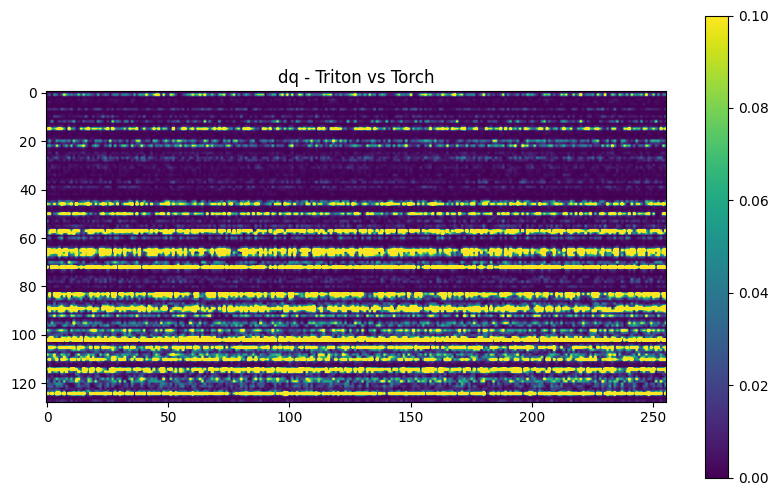

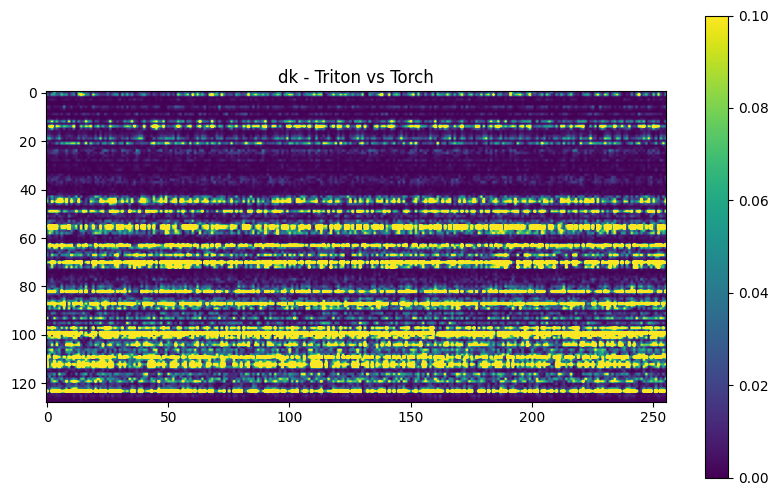

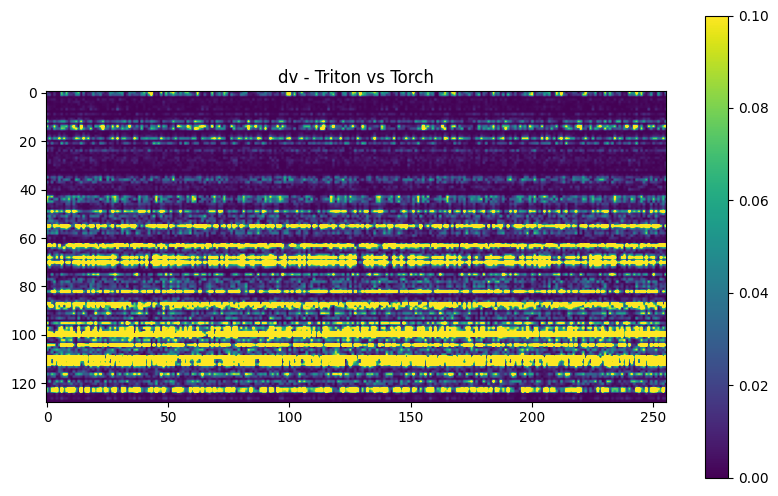

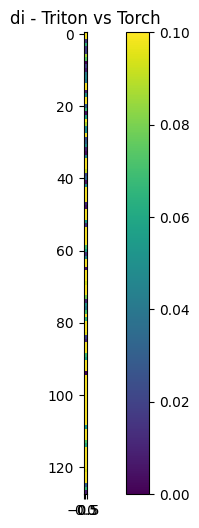

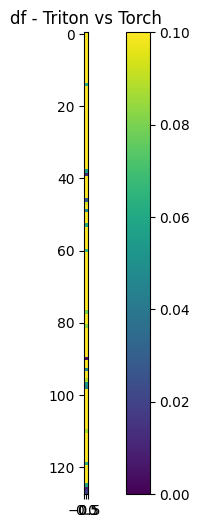

In [19]:
vmax = 0.1
fig = plot_numerical_diffs_single(dQ_tr_p_half, dQ_pt_p, "dq - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dK_tr_p_half, dK_pt_p, "dk - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dV_tr_p_half, dV_pt_p, "dv - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dI_tr_p_half, dI_pt_p.squeeze(-1), "di - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dF_tr_p_half, dF_pt_p.squeeze(-1), "df - Triton vs Torch", vmax=vmax)

## Measure Performance

In [48]:
warmup = 100
rep = 1000

BATCH, H, HEAD_DIM = 2, 8, 128
N_CTX = 2048
dtype = torch.float16
device = torch.device("cuda:0")
q = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
k = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
v = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
ig = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)
fg = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)

dH = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
vecM = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)
vecN = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)

In [49]:
mlstm_bw_pt = mlstm_bw_torch
fn = lambda: mlstm_bw_pt(dH, q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1), vecM.unsqueeze(-1), vecN.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

38.4275016784668

In [50]:
mlstm_bw_pt_compile = torch.compile(mlstm_bw_torch)
fn = lambda: mlstm_bw_pt_compile(dH, q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1), vecM.unsqueeze(-1), vecN.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

12.285845756530762

In [51]:
mlstm_bw_triton = mlstm_bw
fn = lambda: mlstm_bw_triton(dH, q, k, v, ig, fg, vecM, vecN)
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

6.506194591522217

In [52]:
# v1: 2.3992741107940674
# v2: 2.359653949737549 no prints all types are float16
# v3: 2.2989847660064697 no autotuning

In [53]:
start_q = 0
bq = 16
dh = 16

stride_qm = dh
stride_qk = 1


off_q = start_q + torch.arange(bq)
off_kv = torch.arange(dh)

off_q[:, None] * stride_qm + off_kv[None, :]

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15],
        [ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31],
        [ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
        [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63],
        [ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
        [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
        [112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127],
        [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143],
        [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159],
        [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175],
        [1

In [54]:
qs.stride(0), qs.stride(1), qs.stride(2), qs.stride(3)

(32768, 32768, 256, 1)